    # Automatic Jupyter Notebook for OpenML dataset 665: sleuth_case2002

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import openml as oml
import numpy as np
import pandas as pd
from sklearn import dummy
from sklearn.model_selection import train_test_split
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['figure.dpi']= 120
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 

from preamble import *
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from pymongo import MongoClient

The percentage of unique values for the default target attribute in this data set is 0.1293.
Because this is higher than 5% of the dataset we assume that this is a **regression** problem. 

Complexity threshold to determine if an algorithm will be run.


In [2]:
comp = 50000000000000

Calculate baseline accuracy for regression problems using scikit-learn DummyRegressor. 

In [3]:
def regBaseline(data):
    strategies = ['mean', 'median']
    baseDict = {}
    X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    for strat in strategies:
        clf = dummy.DummyRegressor(strategy=strat)
        clf.fit(X_train, y_train)
        baseDict[strat] = clf.score(X_test, y_test)
    return baseDict, y 

Generates a plot of the regression baseline accuracy of the various baseline strategies using scikit-learn DummyRegressor.


In [4]:
def plot_regBaseline(scores, y):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    from collections import namedtuple
    
    fig, ax = plt.subplots()

    strats = scores
    x = np.arange(1, len(y) + 1)
    plt.plot(x, y, "o")
    plt.axhline(y=np.mean(y), color='r', linestyle='--', label='mean '+ r"$R^2$" + ' = ' + str(round(scores['mean'],4)))
    plt.axhline(y=np.median(y), color='b', linestyle='--', label='median '+ r"$R^2$" + ' = ' + str(round(scores['median'],4)))

    maxBaseline = strats[max(strats, key=strats.get)]
    
    ax.set_xlabel('Data point index')
    ax.set_ylabel(data.default_target_attribute)

    plt.legend()
    plt.show()
    return maxBaseline

Generates a plot of the accuracy of the machinelearning algorithms against the baseline.


In [5]:
def plot_alg(scores, maxBaseline):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator
    from collections import namedtuple

    strats = scores
    
    n_groups = len(strats)

    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.1

    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    x = list(strats.keys())
    y = []
    for strat in x:
        y.append(strats[strat])
    markerline, stemlines, baseline = plt.stem(np.arange(n_groups), y, '-.')
    plt.setp(baseline, color='r', linewidth=2)
    plt.xticks(range(len(strats)), list(strats.keys()))
    plt.yticks(np.arange(-1, 1.1, step=0.2))
    plt.yticks(list(plt.yticks()[0]) + [maxBaseline])
    plt.plot()
    ax.set_ylim(ymin=-1)
    ax.set_ylim(ymax=1)
    ax.set_xlim(xmin=-0.1)
    ax.set_xlim(xmax=len(strats)-0.9)
    ax.set_xlabel('Machine Learning Algorithm')
    ax.set_ylabel('$R^2$')
    ax.set_title('Algorithm Performance Predicting Feature: ' + data.default_target_attribute)
    plt.axhline(y=maxBaseline, color='r', linestyle='--', label=maxBaseline)
    plt.gca().get_yticklabels()[len(plt.gca().get_yticklabels())-1].set_color('red')
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show() 

Build Random Forest model from the dataset and compute important features. 

In [6]:
def build_forest(data):    
    X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
    forest = Pipeline([('Imputer', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                       ('classifiers', RandomForestClassifier(n_estimators=100, random_state=0))])
    forest.fit(X,y)
    
    importances = forest.steps[1][1].feature_importances_
    indices = np.argsort(importances)[::-1]
    return data.name, features, importances, indices 

Plot Top-20 important features for the dataset. 

In [7]:
def plot_feature_importances(features, importances, indices):
    a = 0.8
    f_sub = []
    max_features = 20

    for f in range(min(len(features), max_features)): 
            f_sub.append(f)

    # Create a figure of given size
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    # Set title
    ttl = dataset_name

    df = pd.DataFrame(importances[indices[f_sub]][::-1])
    df.plot(kind='barh', ax=ax, alpha=a, legend=False, edgecolor='w', 
            title=ttl, color = [plt.cm.viridis(np.arange(len(df))*10)])

    # Remove grid lines and plot frame
    ax.grid(False)
    ax.set_frame_on(False)

    # Customize title
    ax.set_title(ax.get_title(), fontsize=14, alpha=a, ha='left', x=0, y=1.0)
    plt.subplots_adjust(top=0.9)

    # Customize x tick lables
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.locator_params(axis='x', tight=True, nbins=5)

    # Customize y tick labels
    yticks = np.array(features)[indices[f_sub]][::-1]
    ax.set_yticklabels(yticks, fontsize=8, alpha=a)
    ax.yaxis.set_tick_params(pad=2)
    ax.yaxis.set_ticks_position('none')  
    ax.set_ylim(ax.get_ylim()[0]-0.5, ax.get_ylim()[1]+0.5) 

    # Set x axis text
    xlab = 'Feature importance'
    ax.set_xlabel(xlab, fontsize=10, alpha=a)
    ax.xaxis.set_label_coords(0.5, -0.1)

    # Set y axis text
    ylab = 'Feature'
    ax.set_ylabel(ylab, fontsize=10, alpha=a)
    plt.show() 

Choose desired dataset and generate the most important plot. 

In [8]:
dataset = 665

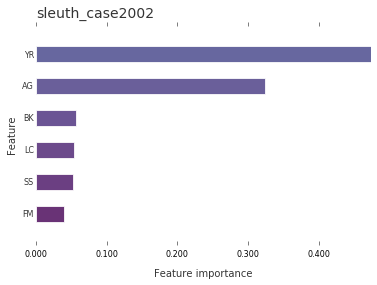

In [9]:
data = oml.datasets.get_dataset(dataset)
dataset_name, features, importances, indices = build_forest(data)
plot_feature_importances(features, importances, indices)

Plot of the regression baseline acuracy of the various baseline strategies using scikit-learn DummyRegressor.

The target feature is: **CD**

The $R^2$ statistic is calculated as a baseline.

The following baseline strategies are used: mean, median.

The strategies work as follow according to the sciki-learn API:

- **mean**: Always predicts the mean of the training set.

- **median**: Always predicts the median of the training set.

[More information.](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)


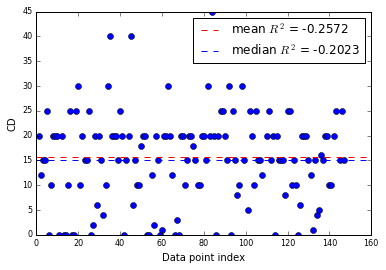

In [10]:
scores, y = regBaseline(data)
maxBaseline = plot_regBaseline(scores, y) 
strats = {} 

Runs the decision tree regressor algorithm on the dataset WIP


In [11]:
#Runs the decision tree regressor algorithm on the dataset
from sklearn import tree
#Running default values, it is recommended to experiment with the values of the parameters below. Try min_samples_leaf=5
clf = tree.DecisionTreeRegressor(max_depth=None, min_samples_leaf=1, max_features=None, max_leaf_nodes=None)
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)
y_train = np.nan_to_num(y_train)

p = len(features)
n = len(X_train)
#computational complexity O(n^2 * p)
complexity = n**2 * p

if complexity <= comp or comp == -1:
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    strats['decision tree'] = acc 
else: 
    print("computation complexity too high, please run manually if desired.") 

Runs the linear regression algorithm on the dataset WIP


In [12]:
#Runs the linear regression algorithm on the dataset
from sklearn.linear_model import LinearRegression
#Running default values, it is recommended to experiment with the values of the parameters below. Try min_samples_leaf=5
clf = LinearRegression()
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)
y_train = np.nan_to_num(y_train)

p = len(features)
n = len(X_train)
#computational complexity O(p^2 *n + P^3)
complexity = p**2 * n + p**3

if complexity <= comp or comp == -1:
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    strats['linear regression'] = acc
else: 
    print("computation complexity too high, please run manually if desired.") 

Runs the random forest regressor algorithm on the dataset WIP


In [13]:
#Runs the random forest algorithm on the dataset.
from sklearn.ensemble import RandomForestRegressor
import math
#Running default values, it is recommended to experiment with the values of the parameters below.
clf = RandomForestRegressor()
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)
y_train = np.nan_to_num(y_train)

p = len(features)
n = len(X_train)
#computational complexity O(n^2 * p * n_trees)
complexity = n**2 * p * 10

if complexity <= comp or comp == -1:
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    strats['random forest'] = acc 
else: 
    print("computation complexity too high, please run manually if desired.") 

Runs the regressor support vector machine algorithm on the dataset WIP


In [14]:
#Runs the regression support vector machine algorithm on the dataset
from sklearn import svm
#Running default values, it is recommended to experiment with the values of the parameters below.
clf = svm.SVR()
X, y, features = data.get_data(target=data.default_target_attribute, return_attribute_names=True); 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)
y_train = np.nan_to_num(y_train)

p = len(features)
n = len(X_train)
#computational complexity O(n^2 * p + n^3)
complexity = n**2 * p + n**3

if complexity <= comp or comp == -1:
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    strats['support vector machine'] = acc 
else: 
    print("computation complexity too high, please run manually if desired.") 

Plot the accuracy of various machine learning algorithms against the baseline. 

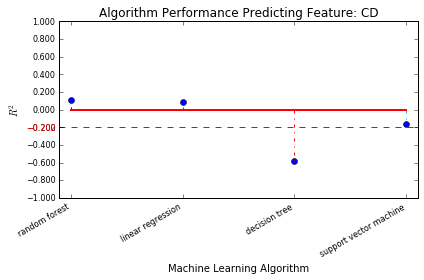

In [15]:
plot_alg(strats,maxBaseline) 